In [1]:
import pandas as pd

card_df = pd.read_csv('../data/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
card_df.shape

(284807, 31)

In [3]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [4]:
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, 
                                                        random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [6]:
print(f'학습 데이터 레이블 값 비율\n{y_train.value_counts() / y_train.shape[0] * 100}\n')
print(f'테스트 데이터 레이블 값 비율\n{y_test.value_counts() / y_test.shape[0] * 100}')

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
                             recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print(f'confusion matrix :\n{confusion}')
    print(f'accuracy : {accuracy:.4f}\nprecision : {precision:.4f}')
    print(f'recall : {recall:.4f}\nf1 : {f1:.4f}\nauc : {roc_auc:.4f}')

In [8]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [9]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

confusion matrix :
[[85283    12]
 [   56    92]]
accuracy : 0.9992
precision : 0.8846
recall : 0.6216
f1 : 0.7302
auc : 0.9599


In [10]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

confusion matrix :
[[85290     5]
 [   36   112]]
accuracy : 0.9995
precision : 0.9573
recall : 0.7568
f1 : 0.8453
auc : 0.9790


<AxesSubplot:xlabel='Amount', ylabel='Density'>

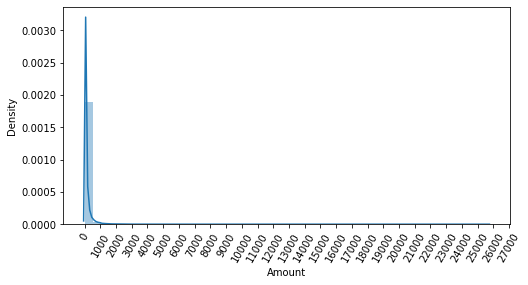

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [12]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [13]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('LogisticRegression')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('\nLightGBM')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

LogisticRegression
confusion matrix :
[[85281    14]
 [   58    90]]
accuracy : 0.9992
precision : 0.8654
recall : 0.6081
f1 : 0.7143
auc : 0.9702

LightGBM
confusion matrix :
[[85290     5]
 [   37   111]]
accuracy : 0.9995
precision : 0.9569
recall : 0.7500
f1 : 0.8409
auc : 0.9779


In [14]:
import numpy as np

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [15]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('LogisticRegression')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print('\nLightGBM')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

LogisticRegression
confusion matrix :
[[85283    12]
 [   59    89]]
accuracy : 0.9992
precision : 0.8812
recall : 0.6014
f1 : 0.7149
auc : 0.9727

LightGBM
confusion matrix :
[[85290     5]
 [   35   113]]
accuracy : 0.9995
precision : 0.9576
recall : 0.7635
f1 : 0.8496
auc : 0.9796


<AxesSubplot:>

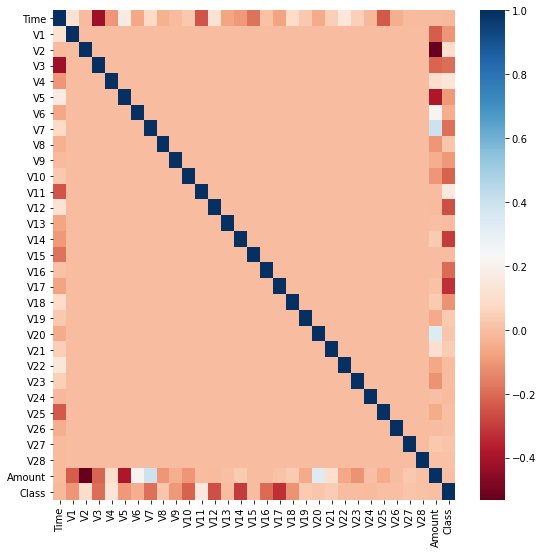

In [16]:
plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap="RdBu")

In [17]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [18]:
outlier_index = get_outlier(card_df, 'V14')
print(outlier_index)

Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [19]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    outlier_index = get_outlier(df_copy, 'V14')
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

In [20]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('LogisticRegression')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print('\nLightGBM')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

LogisticRegression
confusion matrix :
[[85281    14]
 [   48    98]]
accuracy : 0.9993
precision : 0.8750
recall : 0.6712
f1 : 0.7597
auc : 0.9743

LightGBM
confusion matrix :
[[85290     5]
 [   25   121]]
accuracy : 0.9996
precision : 0.9603
recall : 0.8288
f1 : 0.8897
auc : 0.9780


In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_train_over shape: {X_train_over.shape}, y_train_over shape: {y_train_over.shape}')

X_train shape: (199362, 29), y_train shape: (199362,)
X_train_over shape: (398040, 29), y_train_over shape: (398040,)


In [22]:
print('SMOTE 적용 전 레이블 값 분포')
print(y_train.value_counts())
print('\nSMOTE 적용 후')
print(pd.Series(y_train_over).value_counts())

SMOTE 적용 전 레이블 값 분포
0    199020
1       342
Name: Class, dtype: int64

SMOTE 적용 후
1    199020
0    199020
Name: Class, dtype: int64


In [23]:
print('LogisticRegression')
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)
print('\nLightGBM')
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

LogisticRegression
confusion matrix :
[[82937  2358]
 [   11   135]]
accuracy : 0.9723
precision : 0.0542
recall : 0.9247
f1 : 0.1023
auc : 0.9737

LightGBM
confusion matrix :
[[85283    12]
 [   22   124]]
accuracy : 0.9996
precision : 0.9118
recall : 0.8493
f1 : 0.8794
auc : 0.9814


In [24]:
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

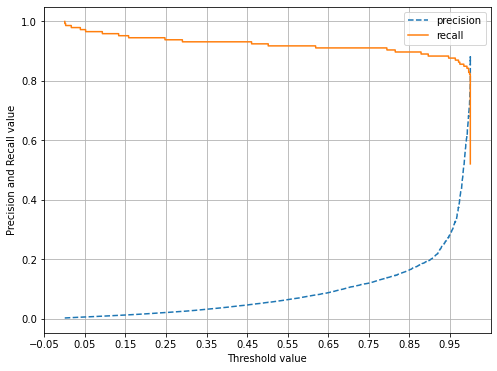

In [25]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

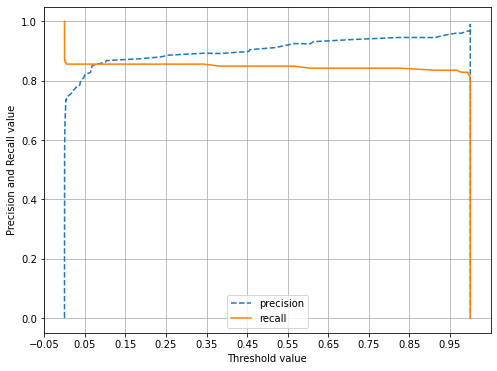

In [26]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:, 1])